In [114]:
import os
import numpy as np
import keras
from keras import layers
import tensorflow as tf
from tensorflow import data as tf_data
import matplotlib.pyplot as plt


In [17]:
print(tf.__version__)

2.15.0


In [ ]:
!unzip trafficsigns_dataset_withtype.zip
%ls

In [5]:
dataset_directory = "trafficsigns_dataset"

# Get class names by listing directories
class_names = sorted(os.listdir(dataset_directory))  # Ensure it's sorted to match the order used by TensorFlow
print("Class names:", class_names)

# Now you can use 'class_names' in your code as needed
print("Class names and their corresponding indices:")
for index, name in enumerate(class_names):
    print(f"Class {index}: {name}")

Class names: ['.DS_Store', 'Readme.txt', 'diamond', 'hex', 'round', 'square', 'triangle']
Class names and their corresponding indices:
Class 0: .DS_Store
Class 1: Readme.txt
Class 2: diamond
Class 3: hex
Class 4: round
Class 5: square
Class 6: triangle


In [6]:
image_size = (28, 28)
batch_size = 32

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "trafficsigns_dataset",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 3699 files belonging to 5 classes.
Using 2960 files for training.
Using 739 files for validation.


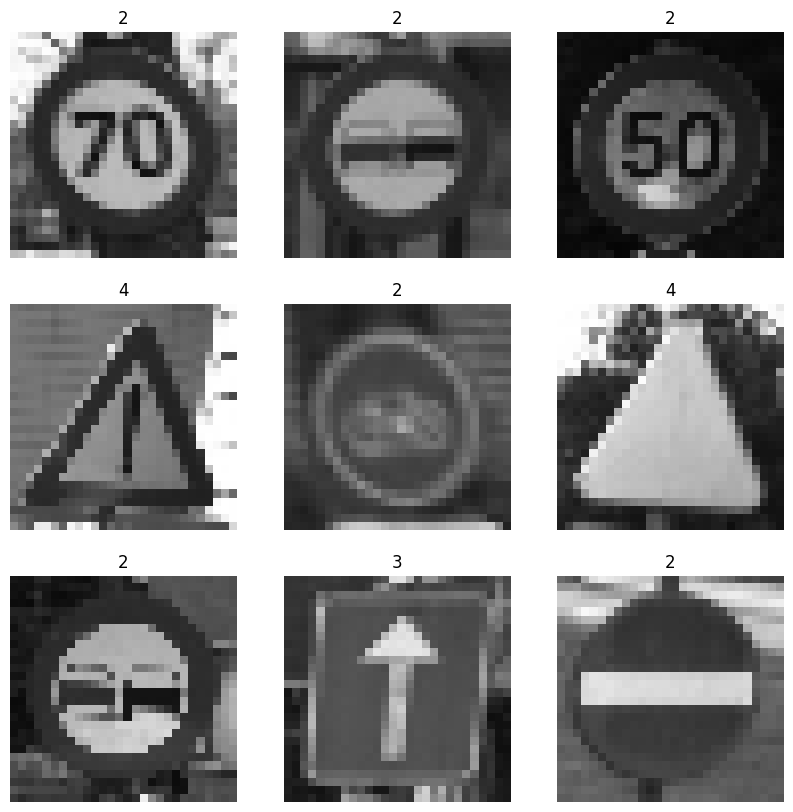

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [9]:
#indicates that even though the images look black and white, they're being treated as RGB
for images, labels in train_ds.take(1):
    print(images.shape)

(32, 28, 28, 3)


In [10]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images


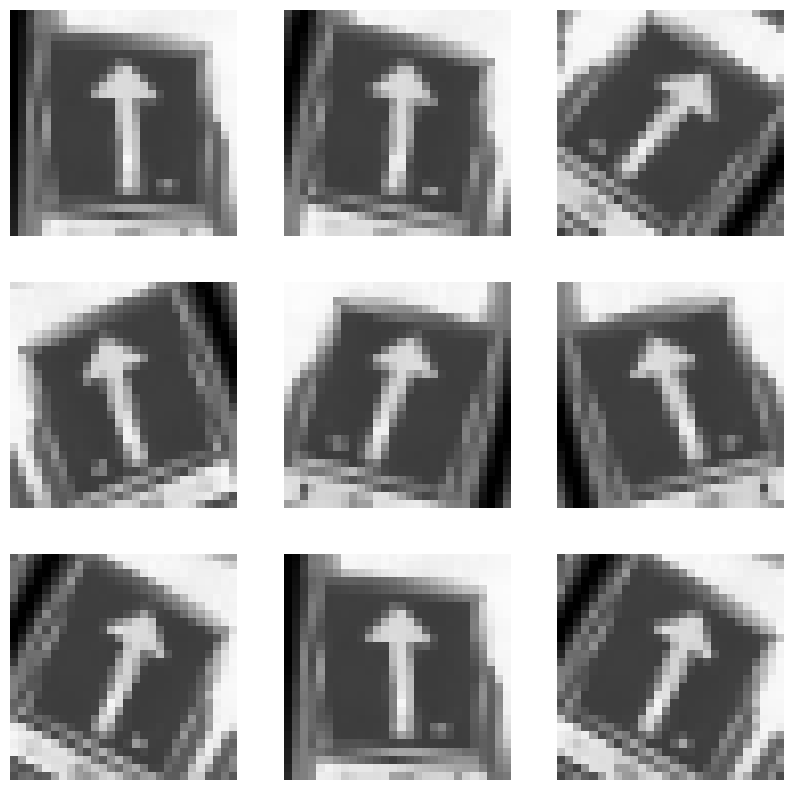

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")


In [12]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)


In [ ]:
pip install graphviz==0.20.3 --upgrade

   ---------------------------------------- 0.0/47.1 kB ? eta -:--:--
   ---------------------------------------- 47.1/47.1 kB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


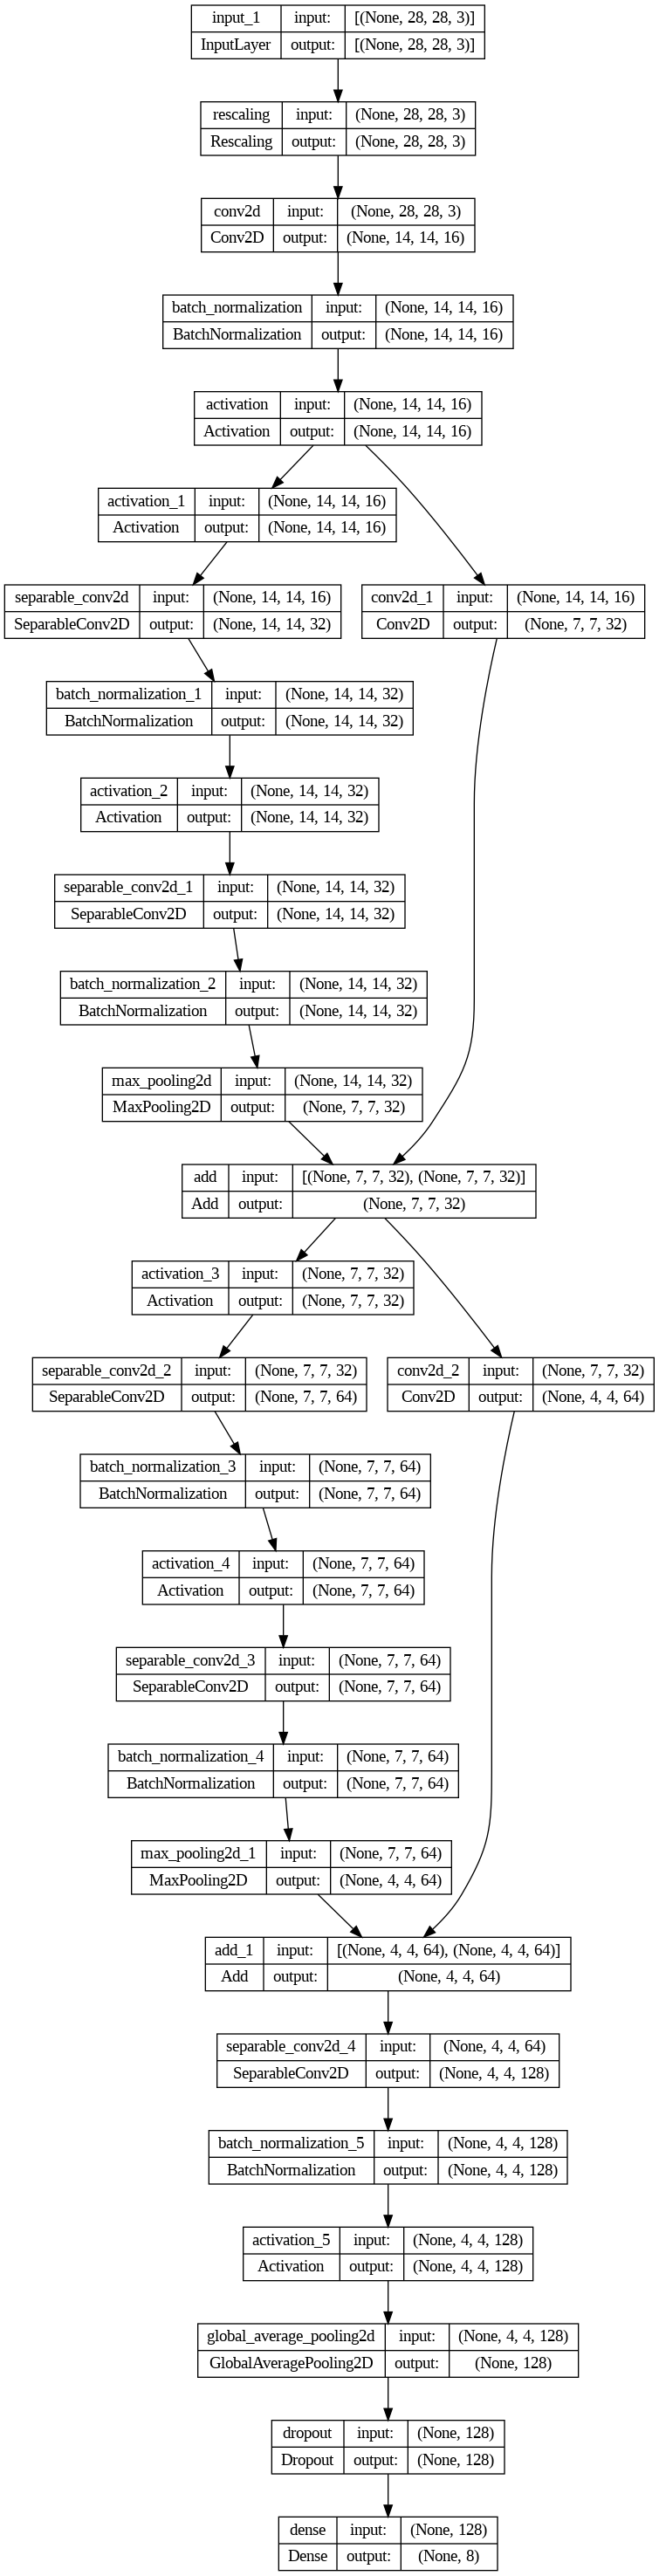

In [13]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [32, 64]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
        activation = 'sigmoid'
    else:
        units = num_classes
        activation = 'softmax'

    x = layers.Dropout(0.5)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

image_size = (28, 28)  # Spatial dimensions
model = make_model(input_shape=image_size + (3,), num_classes=8)  # Correctly adds the channel dimension

#model = make_model(input_shape=image_size + (1,), num_classes=8)
keras.utils.plot_model(model, show_shapes=True)


In [14]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
epochs = 10
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10
93/93 [==============================] - 12s 45ms/step - loss: 6.3562 - accuracy: 0.3605 - val_loss: 6.5742 - val_accuracy: 0.4844
Epoch 2/10
93/93 [==============================] - 5s 53ms/step - loss: 4.8095 - accuracy: 0.4142 - val_loss: 2.6657 - val_accuracy: 0.4844
Epoch 3/10
93/93 [==============================] - 4s 40ms/step - loss: 3.8628 - accuracy: 0.3615 - val_loss: 2.3133 - val_accuracy: 0.3329
Epoch 4/10
93/93 [==============================] - 4s 40ms/step - loss: 2.9263 - accuracy: 0.2976 - val_loss: 2.0931 - val_accuracy: 0.1583
Epoch 5/10
93/93 [==============================] - 5s 52ms/step - loss: 2.8745 - accuracy: 0.2895 - val_loss: 2.1383 - val_accuracy: 0.2233
Epoch 6/10
93/93 [==============================] - 4s 40ms/step - loss: 2.7410 - accuracy: 0.2453 - val_loss: 2.3849 - val_accuracy: 0.3180
Epoch 7/10
93/93 [==============================] - 4s 41ms/step - loss: 2.5389 - accuracy: 0.2486 - val_loss: 2.7098 - val_accuracy: 0.2950
Epoch 8/10
9

In [ ]:
# epochs = 10

# callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
# ]
# model.compile(
#     optimizer=keras.optimizers.Adam(3e-4),
#     loss=keras.losses.BinaryCrossentropy(from_logits=True),
#     metrics=[keras.metrics.BinaryAccuracy(name="acc")],
# )
# model.fit(
#     train_ds,
#     epochs=epochs,
#     callbacks=callbacks,
#     validation_data=val_ds,
# )


AttributeError: module 'keras' has no attribute 'ops'

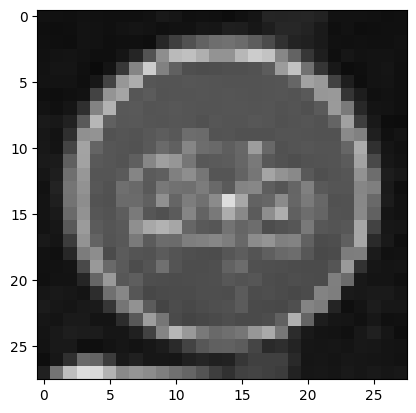

In [16]:
img = keras.utils.load_img("trafficsigns_dataset/round/bicycle/00004_00000.png", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

In [18]:

predictions = model.predict(img_array)

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 28, 28, 3), found shape=(None, 28, 3)


In [ ]:
predicted_class = np.argmax(predictions, axis=1)
print("Predicted class:", predicted_class)

Predicted class: [2]


# New Section

In [60]:
import pandas as pd


In [61]:
sign_type_class_names = ['rightofway','stop','bicycle','limitedtraffic','noentry','noparking','roundabout','speed','trafficdirective','traveldirection','continue',
                         'crossing','laneend','parking','giveway','warning']

In [62]:
# Get image names from sign-type directories
rw = sorted(os.listdir("trafficsigns_dataset/diamond/rightofway"))
st = sorted(os.listdir("trafficsigns_dataset/hex/stop"))
bc = sorted(os.listdir("trafficsigns_dataset/round/bicycle"))
lt = sorted(os.listdir("trafficsigns_dataset/round/limitedtraffic"))
ne = sorted(os.listdir("trafficsigns_dataset/round/noentry"))
np = sorted(os.listdir("trafficsigns_dataset/round/noparking"))
ra = sorted(os.listdir("trafficsigns_dataset/round/roundabout"))
sp = sorted(os.listdir("trafficsigns_dataset/round/speed"))
td = sorted(os.listdir("trafficsigns_dataset/round/trafficdirective"))
trvd = sorted(os.listdir("trafficsigns_dataset/round/traveldirection"))
ct = sorted(os.listdir("trafficsigns_dataset/square/continue"))
cr = sorted(os.listdir("trafficsigns_dataset/square/crossing"))
le = sorted(os.listdir("trafficsigns_dataset/square/laneend"))
pk = sorted(os.listdir("trafficsigns_dataset/square/parking"))
gw = sorted(os.listdir("trafficsigns_dataset/triangle/giveway"))
wn = sorted(os.listdir("trafficsigns_dataset/triangle/warning"))

In [69]:
sign_type_dict = []

for i in rw:
  sign_type_dict.append(["trafficsigns_dataset/diamond/rightofway/" + i,"rightofway"])

for i in st:
  sign_type_dict.append(["trafficsigns_dataset/hex/stop/" + i,"stop"])

for i in bc:
  sign_type_dict.append(["trafficsigns_dataset/round/bicycle/" + i,"bicycle"])

for i in lt:
  sign_type_dict.append(["trafficsigns_dataset/round/limitedtraffic/" + i,"limitedtraffic"])

for i in ne:
  sign_type_dict.append(["trafficsigns_dataset/round/noentry/" + i,"noentry"])

for i in np:
  sign_type_dict.append(["trafficsigns_dataset/round/noparking/" + i,"noparking"])

for i in ra:
  sign_type_dict.append(["trafficsigns_dataset/round/roundabout/" + i,"roundabout"])

for i in sp:
  sign_type_dict.append(["trafficsigns_dataset/round/speed/" + i,"speed"])

for i in td:
  sign_type_dict.append(["trafficsigns_dataset/round/trafficdirective/" + i,"trafficdirective"])

for i in trvd:
  sign_type_dict.append(["trafficsigns_dataset/round/traveldirection/" + i,"traveldirection"])

for i in ct:
  sign_type_dict.append(["trafficsigns_dataset/square/continue/" + i,"continue"])

for i in cr:
  sign_type_dict.append(["trafficsigns_dataset/square/crossing/" + i,"crossing"])

for i in le:
  sign_type_dict.append(["trafficsigns_dataset/square/laneend/" + i,"laneend"])

for i in pk:
  sign_type_dict.append(["trafficsigns_dataset/square/parking/" + i,"parking"])

for i in gw:
  sign_type_dict.append(["trafficsigns_dataset/triangle/giveway/" + i,"giveway"])

for i in wn:
  sign_type_dict.append(["trafficsigns_dataset/triangle/warning/" + i,"warning"])

In [70]:
print(sign_type_dict)

[['trafficsigns_dataset/diamond/rightofway/00032_00000.png', 'rightofway'], ['trafficsigns_dataset/diamond/rightofway/00032_00001.png', 'rightofway'], ['trafficsigns_dataset/diamond/rightofway/00032_00002.png', 'rightofway'], ['trafficsigns_dataset/diamond/rightofway/00037_00000.png', 'rightofway'], ['trafficsigns_dataset/diamond/rightofway/00037_00001.png', 'rightofway'], ['trafficsigns_dataset/diamond/rightofway/00037_00002.png', 'rightofway'], ['trafficsigns_dataset/diamond/rightofway/00039_00000.png', 'rightofway'], ['trafficsigns_dataset/diamond/rightofway/00039_00001.png', 'rightofway'], ['trafficsigns_dataset/diamond/rightofway/00039_00002.png', 'rightofway'], ['trafficsigns_dataset/diamond/rightofway/00042_00000.png', 'rightofway'], ['trafficsigns_dataset/diamond/rightofway/00042_00001.png', 'rightofway'], ['trafficsigns_dataset/diamond/rightofway/00042_00002.png', 'rightofway'], ['trafficsigns_dataset/diamond/rightofway/00044_00000.png', 'rightofway'], ['trafficsigns_dataset/d

In [71]:
stdf = pd.DataFrame(data=sign_type_dict, columns=['imgPath', 'class'])

stdf.head()

,imgPath,class
0,trafficsigns_dataset/diamond/rightofway/00032_...,rightofway
1,trafficsigns_dataset/diamond/rightofway/00032_...,rightofway
2,trafficsigns_dataset/diamond/rightofway/00032_...,rightofway
3,trafficsigns_dataset/diamond/rightofway/00037_...,rightofway
4,trafficsigns_dataset/diamond/rightofway/00037_...,rightofway


In [72]:
from tensorflow.keras import datasets, models
from sklearn.model_selection import train_test_split

In [86]:
train_data, test_data = train_test_split(stdf, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

In [74]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [99]:
INPUT_DIM = (28,28,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 16

In [100]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [94]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 2352)              0         
                                                                 
 dense_7 (Dense)             (None, 256)               602368    
                                                                 
 dense_8 (Dense)             (None, 15)                3855      
                                                                 
Total params: 606223 (2.31 MB)
Trainable params: 606223 (2.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


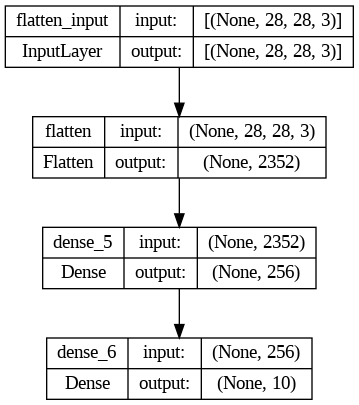

In [79]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [101]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [102]:
train_data['class'] = train_data['class'].astype('str')
val_data['class'] = val_data['class'].astype('str')

In [103]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 28

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="imgPath",
        y_col="class",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="imgPath",
        y_col="class",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2220 validated image filenames belonging to 16 classes.
Found 739 validated image filenames belonging to 16 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="imgPath". These filename(s) will be ignored.
  warnings.warn(


In [104]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

<ipython-input-104-243f5d5117d3>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)


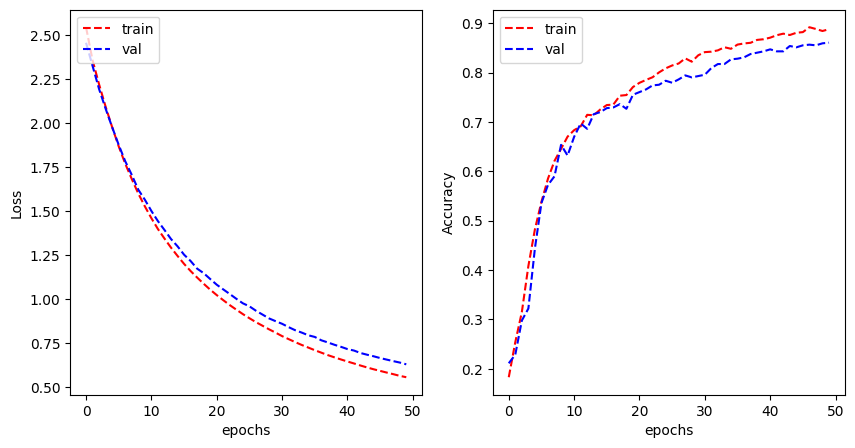

In [105]:
plot_learning_curve(history.history['loss'], history.history['val_loss'],
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [110]:
test_data['class'] = test_data['class'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="imgPath",
        y_col="class",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 739 validated image filenames belonging to 16 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="imgPath". These filename(s) will be ignored.
  warnings.warn(


In [111]:
model.evaluate(test_generator)

739/739 [==============================] - 2s 3ms/step - loss: 0.6284 - categorical_accuracy: 0.8606


[0.6284047961235046, 0.8606224656105042]

In [112]:
label_names = {'rightofway' : 0, 'stop' : 1, 'bicycle' : 2, 'limitedtraffic' : 3, 'noentry' : 4, 'noparking' : 5, 'roundabout' : 6, 'speed' : 7, 'trafficdirective' : 8, 'traveldirection' : 9,
               'continue' : 10, 'crossing' : 11, 'laneend' : 12, 'parking' : 13, 'giveway' : 14, 'warning' : 15}

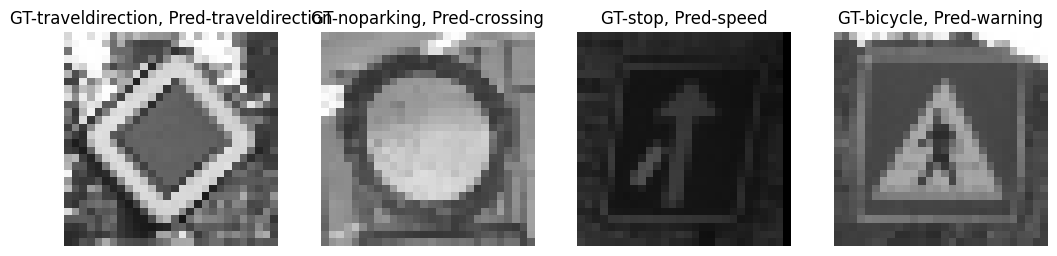

In [115]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))

        else:
            break

        plt.axis('off')